In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import pickle

# Prepare data

In [2]:
data = pd.read_pickle("../preprocessed_data/uk/data.p")

In [6]:
sorted(data.Category.unique())

['Accounting & Finance Jobs',
 'Admin Jobs',
 'Charity & Voluntary Jobs',
 'Consultancy Jobs',
 'Creative & Design Jobs',
 'Customer Services Jobs',
 'Domestic help & Cleaning Jobs',
 'Energy, Oil & Gas Jobs',
 'Engineering Jobs',
 'Graduate Jobs',
 'HR & Recruitment Jobs',
 'Healthcare & Nursing Jobs',
 'Hospitality & Catering Jobs',
 'IT Jobs',
 'Legal Jobs',
 'Logistics & Warehouse Jobs',
 'Maintenance Jobs',
 'Manufacturing Jobs',
 'Other/General Jobs',
 'PR, Advertising & Marketing Jobs',
 'Part time Jobs',
 'Property Jobs',
 'Retail Jobs',
 'Sales Jobs',
 'Scientific & QA Jobs',
 'Social work Jobs',
 'Teaching Jobs',
 'Trade & Construction Jobs',
 'Travel Jobs']

In [3]:
for c in ['ContractTime','Category']:
    data[c] = data[c].astype("category")

In [4]:
X = data.drop(columns = "SalaryNormalized")
label = data["SalaryNormalized"].values

In [5]:
train_data = lgb.Dataset(X, label=label, free_raw_data=False)

# Cross validate

In [6]:
param = {'num_leaves': 4, 'min_data_in_leaf': 1, 'objective': 'mape'}
param['metric'] = 'mape'

/Users/davide/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


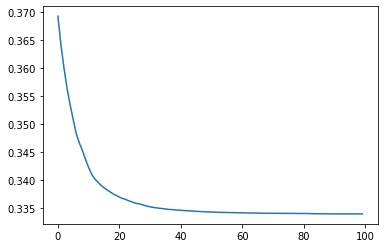

In [14]:
num_round = 100
scores = lgb.cv(param, train_data, num_round, nfold=5)
plt.plot(scores['mape-mean'])

# Fit

In [8]:
bst = lgb.train(param, train_data, num_round)

In [9]:
# save features
features = ["contract_time","category","region"]
with open("features.p","wb") as f: pickle.dump(features,f)

In [10]:
# save_model
with open("bst.p","wb") as f:
    pickle.dump(bst,f)

In [12]:
# example

# load
class ModelByRegion:
    def __init__(self,bst,scale = 34122.5775755):
        self.bst = bst
        self.scale = scale
        # from https://www.statista.com/statistics/708972/average-annual-nominal-wages-of-employees-italy-by-region/
        self.salary_by_region = dict(
            Lombardia=31446,
            Trentino=30786,
            Lazio=30496,
            Emilia=30273,
            Liguria=30190,
            Piemonte=29556,
            Veneto=29286,
            Friuli=29222,
            Aosta=29202,
            Toscana=28513,
            Marche=27411,
            Abruzzo=27039,
            Campania=26904,
            Umbria=26737,
            Puglia=26410,
            Molise=26263,
            Sicilia=26133,
            Sardegna=26042,
            Calabria=25079,
            Basilicata=24308,
        )
        
    def predict(self,contract_time,category,region):
        x = pd.DataFrame(dict(contract_time=[contract_time], category=[category]),dtype="category")
        return (self.bst.predict(x) / self.scale) * self.salary_by_region[region]

    
bst = pd.read_pickle("bst.p")
model = ModelByRegion(bst)

contract_time = "permanent"
category = "Accounting & Finance Jobs"
region = "Lombardia"

model.predict(contract_time,category,region)

array([23039.87288583])

In [13]:
X

,ContractTime,Category
0,permanent,Engineering Jobs
1,permanent,Engineering Jobs
2,permanent,Engineering Jobs
3,permanent,Engineering Jobs
4,permanent,Engineering Jobs
...,...,...
244763,contract,Teaching Jobs
244764,contract,Teaching Jobs
244765,contract,Teaching Jobs
244766,contract,Teaching Jobs
